Be sure to install the dependencies:
```bash
conda install --yes msmbuilder pandas matplotlib seaborn scikit-learn
```
`msmbuilder` was just updated on 19 Oct 2016, so you might want to reinstall:
```bash
conda uninstall --yes scikit-learn msmbuilder
conda clean -pltis --yes
conda install --yes msmbuilder
```

In [1]:
%matplotlib inline

In [2]:
import matplotlib as mpl
mpl.use('Agg')
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import seaborn

import numpy as np
import pandas as pd

/Users/wkc/miniconda3/envs/microbiome-timeseries-analysis/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
def read_patient_data(patient):
    filename = '../data/cholera/%s_gordon.taxa_count.sorted.txt' % patient

    # Load data
    df = pd.read_table(filename, delim_whitespace=True)

    # Extract sorted sample labels
    samples = list(df.index)
    nsamples = len(samples)

    # Extract feature names
    features = list(df.columns)
    nfeatures = len(features)

    # Extract feature vectors
    patient_timeseries = df.as_matrix()

    return [samples, features, patient_timeseries]

/Users/wkc/miniconda3/envs/microbiome-timeseries-analysis/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/wkc/miniconda3/envs/microbiome-timeseries-analysis/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/wkc/miniconda3/envs/microbiome-timeseries-analysis/lib/python2.7/site-packages/msmbuilder/decomposition/tica.py:405: UserWarning: The number of features (46) is greater than the len

Projecting all patient data...
Making figures...


/Users/wkc/miniconda3/envs/microbiome-timeseries-analysis/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


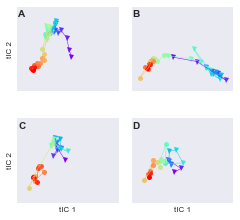

In [4]:
#
# Analyze using standard tICA
#

import msmbuilder.cluster
import msmbuilder.hmm
import sklearn.cluster
from msmbuilder.decomposition import tICA

n_components = 2 # number of dimensions to retain
lag_time = 1 # lag time (in sampling intervals)

#
# Perform tICA clustering on each depth separately
#

# Get colormap
from matplotlib.pyplot import cm

patient_indices_to_plot = [0, 1, 2, 3] # CHANGE THIS: indexes into 'patients' array below

# Construct a tICA projection from all data.
print('Projecting all patient data...')
patients = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
data = list()
for (subplot_index, patient) in enumerate(patients):
    # Load patient data
    [samples, features, patient_timeseries] = read_patient_data(patient)
    data.append(patient_timeseries)
    nsamples = len(samples)
    nfeatures = len(features)
# Create tICA projection and retrieve projected data
tica = tICA(n_components=n_components, lag_time=lag_time, kinetic_mapping=True)
projected_data = tica.fit_transform(data)

# Make plots
print('Making figures...')
fig = plt.figure(figsize=[3.5,3.5])
subplot_nx = 2
subplot_ny = 2
axis_label_fontsize = 8 # font size for axes labels
subplot_label_fontsize = 10 # font size for patient labels
for (plot_index, patient_index) in enumerate(patient_indices_to_plot):    
    patient = patients[patient_index]
    plot_column = plot_index % subplot_ny
    plot_row = plot_index / subplot_ny
    
    # Load patient data
    [samples, features, patient_timeseries] = read_patient_data(patient)
    nsamples = len(samples)
    nfeatures = len(features)
    projection = projected_data[patient_index]
    cmap = cm.rainbow(np.linspace(0,1,nsamples))
    
    ax = plt.subplot(subplot_ny, subplot_nx, plot_index+1)
    ax.set_color_cycle(cmap)

    # Plot with time-varying color
    for i in range(nsamples):
        if 'diarrhea' in samples[i]:
            marker = 'v'
        else:
            marker = 'o'
        ax.plot(projection[i,0], projection[i,1], marker, markersize=5)
    for i in range(nsamples-1):
        ax.plot(projection[i:i+2,0], projection[i:i+2,1], '-', markersize=3, linewidth=0.5)

    # Fix up axes.
    if plot_column == 0:
        plt.ylabel('tIC 2', fontsize=axis_label_fontsize)
    if plot_row == (subplot_ny-1):
        plt.xlabel('tIC 1', fontsize=axis_label_fontsize)
    plt.xticks([])
    plt.yticks([])

    # Add a circle to around endpoint
    # Couldn't figure out how to get this to work
    #mpl.patches.Circle(projection[-1,:], radius=1)
    
    # Make sure axes are equal among all plots
    plt.axis('square')
    plt.axis([-2, +4, -2.5, +2.5])
    
    # Label with patient index
    ax.text(-1.95, +1.90,  '%s' % patient, fontsize=subplot_label_fontsize, fontweight='bold')

plt.tight_layout()
plt.savefig('../figures/cholera_tICA-projections.pdf')

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
def reverse_colourmap(cmap, name = 'my_cmap_r'):
    """
    In: 
    cmap, name 
    Out:
    my_cmap_r

    Explanation:
    t[0] goes from 0 to 1
    row i:   x  y0  y1 -> t[0] t[1] t[2]
                   /
                  /
    row i+1: x  y0  y1 -> t[n] t[1] t[2]

    so the inverse should do the same:
    row i+1: x  y1  y0 -> 1-t[0] t[2] t[1]
                   /
                  /
    row i:   x  y1  y0 -> 1-t[n] t[2] t[1]
    """        
    reverse = []
    k = []   

    for key in cmap._segmentdata:    
        k.append(key)
        channel = cmap._segmentdata[key]
        data = []

        for t in channel:                    
            data.append((1-t[0],t[2],t[1]))            
        reverse.append(sorted(data))    

    LinearL = dict(zip(k,reverse))
    my_cmap_r = mpl.colors.LinearSegmentedColormap(name, LinearL) 
    return my_cmap_r

colormap = reverse_colourmap(mpl.cm.bwr, 'rwb')

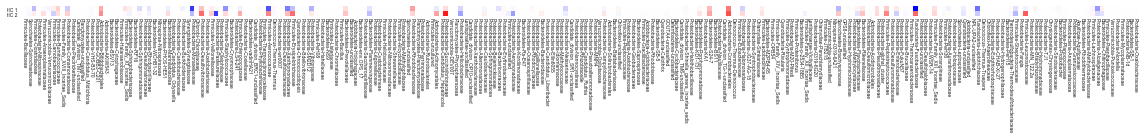

In [6]:
# Plot tICs

def scaledimage(W, pixwidth=1, ax=None, colormap=colormap, grayscale=False, figsize=[20,3]):
    """
    Do intensity plot, similar to MATLAB imagesc()
    W = intensity matrix to visualize
    pixwidth = size of each W element
    ax = matplotlib Axes to draw on 
    grayscale = use grayscale color map
    Rely on caller to .show()
    
    Code from: https://gist.github.com/davidandrzej/940072
    
    """
    import numpy as NP
    import matplotlib.pyplot as P
    import matplotlib.ticker as MT
    import matplotlib.cm as CM

    # Ensure white is zero
    maxabs = abs(W).max()
    clim = [-maxabs, +maxabs]
    
    # N = rows, M = column
    (N, M) = W.shape 
    # Need to create a new Axes?
    if(ax == None):
        ax = P.figure(figsize=figsize).gca()
    # extents = Left Right Bottom Top
    exts = (0, pixwidth * M, 0, pixwidth * N)
    if(grayscale):
        ax.imshow(W,
                  interpolation='nearest',
                  cmap=CM.gray,
                  extent=exts,
                  clim=clim)
    else:
        ax.imshow(W,
                  interpolation='nearest',
                  cmap=colormap,
                  extent=exts,
                  clim=clim)

    ax.xaxis.set_major_locator(MT.NullLocator())
    ax.yaxis.set_major_locator(MT.NullLocator())
    return ax

scaledimage(tica.eigenvectors_.T, pixwidth=1);
plt.text(-3,1,'tIC 1', fontsize=5);
plt.text(-3,0,'tIC 2', fontsize=5);
for (feature_index, feature) in enumerate(features):
    plt.text(feature_index, -1, feature, rotation=-90, fontsize=5)
plt.savefig('../figures/cholera_tICs.pdf');

/Users/wkc/miniconda3/envs/microbiome-timeseries-analysis/lib/python2.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if sys.path[0] == '':
/Users/wkc/miniconda3/envs/microbiome-timeseries-analysis/lib/python2.7/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/wkc/miniconda3/envs/microbiome-timeseries-analysis/lib/python2.7/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


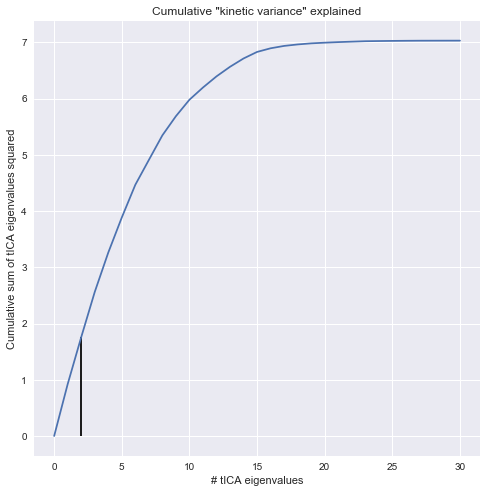

In [7]:
# Create tICA projection with many components
max_components = 30
tica = tICA(n_components=max_components, lag_time=lag_time, kinetic_mapping=True)
projected_data = tica.fit_transform(data)

# Plot the fraction of kinetic variance explained by each number of eigenvalues
eigs = tica.eigenvalues_
plt.figure(figsize=[8,8])
cumulative_sum = np.zeros([max_components+1], np.float64)
cumulative_sum[1:] = np.cumsum(eigs ** 2)
plt.plot(cumulative_sum)
plt.hold(True)
dim = 2
plt.vlines(dim, 0, np.sum((eigs ** 2)[:dim]))
plt.xlabel('# tICA eigenvalues')
plt.ylabel('Cumulative sum of tICA eigenvalues squared')
plt.title('Cumulative "kinetic variance" explained');
plt.savefig('../figures/cholera_kinetic-variance-explained.pdf');

Projecting all patient data...
Making figures...


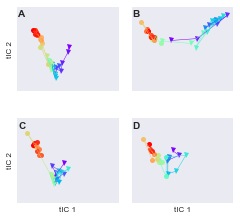

In [8]:
#
# Analyze using sparse tICA
#

import msmbuilder.cluster
import msmbuilder.hmm
import sklearn.cluster
from msmbuilder.decomposition import SparseTICA

n_components = 2 # number of dimensions to retain
lag_time = 1 # lag time (in sampling intervals)

#
# Perform tICA clustering on each depth separately
#

# Get colormap
from matplotlib.pyplot import cm

patient_indices_to_plot = [0, 1, 2, 3] # CHANGE THIS: indexes into 'patients' array below

# Construct a tICA projection from all data.
print('Projecting all patient data...')
patients = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
data = list()
for (subplot_index, patient) in enumerate(patients):
    # Load patient data
    [samples, features, patient_timeseries] = read_patient_data(patient)
    data.append(patient_timeseries)
    nsamples = len(samples)
    nfeatures = len(features)
# Create tICA projection and retrieve projected data
rho = 0.01 # sparsity regularization strength
tica = SparseTICA(n_components=n_components, rho=rho, lag_time=lag_time, kinetic_mapping=True)
projected_data = tica.fit_transform(data)

# Make plots
print('Making figures...')
fig = plt.figure(figsize=[3.5,3.5])
subplot_nx = 2
subplot_ny = 2
axis_label_fontsize = 8 # font size for axes labels
subplot_label_fontsize = 10 # font size for patient labels
for (plot_index, patient_index) in enumerate(patient_indices_to_plot):    
    patient = patients[patient_index]
    plot_column = plot_index % subplot_ny
    plot_row = plot_index / subplot_ny
    
    # Load patient data
    [samples, features, patient_timeseries] = read_patient_data(patient)
    nsamples = len(samples)
    nfeatures = len(features)
    projection = projected_data[patient_index]
    cmap = cm.rainbow(np.linspace(0,1,nsamples))
    
    ax = plt.subplot(subplot_ny, subplot_nx, plot_index+1)
    ax.set_color_cycle(cmap)

    # Plot with time-varying color
    for i in range(nsamples):
        if 'diarrhea' in samples[i]:
            marker = 'v'
        else:
            marker = 'o'
        ax.plot(projection[i,0], projection[i,1], marker, markersize=5)
    for i in range(nsamples-1):
        ax.plot(projection[i:i+2,0], projection[i:i+2,1], '-', markersize=3, linewidth=0.5)

    # Fix up axes.
    if plot_column == 0:
        plt.ylabel('tIC 2', fontsize=axis_label_fontsize)
    if plot_row == (subplot_ny-1):
        plt.xlabel('tIC 1', fontsize=axis_label_fontsize)
    plt.xticks([])
    plt.yticks([])

    # Add a circle to around endpoint
    # Couldn't figure out how to get this to work
    #mpl.patches.Circle(projection[-1,:], radius=1)
    
    # Make sure axes are equal among all plots
    plt.axis('square')
    plt.axis([-2, +4, -2.5, +2.5])
    
    # Label with patient index
    ax.text(-1.95, +1.90,  '%s' % patient, fontsize=subplot_label_fontsize, fontweight='bold')

plt.tight_layout()
plt.savefig('../figures/cholera_sparse-tICA-projections.pdf')

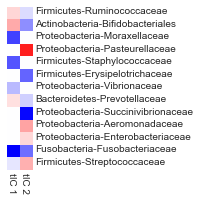

In [9]:
# Plot sparse tICs

# Determine which features have nonzero weights
feature_indices = list()
for (feature_index, feature) in enumerate(features):
    if np.any(tica.eigenvectors_[feature_index,:] != 0):
        feature_indices.append(feature_index)

fontsize=10
scaledimage(tica.eigenvectors_[feature_indices,:], pixwidth=1);
plt.text(0, -0.7,'tIC 1', rotation=-90, fontsize=fontsize);
plt.text(1, -0.7,'tIC 2', rotation=-90, fontsize=fontsize);
for [nonzero_feature_index, feature_index] in enumerate(feature_indices):
    feature = features[feature_index]
    plt.text(2.2, len(feature_indices) - nonzero_feature_index - 0.5, feature, rotation=0, fontsize=fontsize)
plt.savefig('../figures/cholera_sparse-tICs.pdf');

/Users/wkc/miniconda3/envs/microbiome-timeseries-analysis/lib/python2.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if sys.path[0] == '':


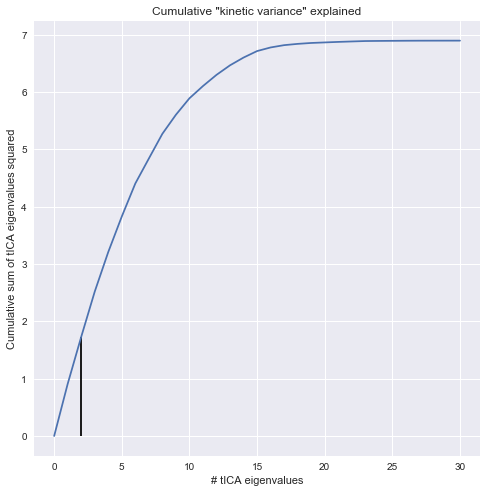

In [10]:
# Create Sparse tICA projection with many components
max_components = 30
tica = SparseTICA(n_components=max_components, rho=rho, lag_time=lag_time, kinetic_mapping=True)
projected_data = tica.fit_transform(data)

# Plot the fraction of kinetic variance explained by each number of eigenvalues
eigs = tica.eigenvalues_
plt.figure(figsize=[8,8])
cumulative_sum = np.zeros([max_components+1], np.float64)
cumulative_sum[1:] = np.cumsum(eigs ** 2)
plt.plot(cumulative_sum)
plt.hold(True)
dim = 2
plt.vlines(dim, 0, np.sum((eigs ** 2)[:dim]))
plt.xlabel('# tICA eigenvalues')
plt.ylabel('Cumulative sum of tICA eigenvalues squared')
plt.title('Cumulative "kinetic variance" explained');
plt.savefig('../figures/cholera_sparse-kinetic-variance.pdf');